### Homework II

dataset used: bikeshare.csv

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

In [2]:
# load dataset, configure time variable
bk = pd.read_csv('/Users/Tochi/Documents/toculars-repo/Homework/Homework 2/bikeshare.csv', 
                 date_parser='datetime')

#### Exploratory Analysis

numeric variables

In [3]:
# for exploratory analysis
bk['month'] = pd.DatetimeIndex(bk['datetime']).month
bk['year'] = pd.DatetimeIndex(bk['datetime']).year
bk['hour'] = pd.DatetimeIndex(bk['datetime']).hour

In [4]:
# viewing dataset
bk.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,year,hour
0,2011-01-01 00:00:00,Spring,0,0,Clear Skies,9.84,14.395,81,0.0,16,1,2011,0
1,2011-01-01 01:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,40,1,2011,1
2,2011-01-01 02:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,32,1,2011,2
3,2011-01-01 03:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,13,1,2011,3
4,2011-01-01 04:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,1,1,2011,4


In [5]:
# checking number of rows
bk.shape[0]

10886

In [6]:
# no missing observations
bk.isnull().sum().sum()

0

In [7]:
bk.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,month,year,hour
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.23086,23.655084,61.886460,12.799395,191.574132,6.521495,2011.501929,11.541613
std,0.166599,0.466159,7.79159,8.474601,19.245033,8.164537,181.144454,3.444373,0.500019,6.915838
min,0.000000,0.000000,0.82000,0.760000,0.000000,0.000000,1.000000,1.000000,2011.000000,0.000000
25%,0.000000,0.000000,13.94000,16.665000,47.000000,7.001500,42.000000,4.000000,2011.000000,6.000000
50%,0.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,7.000000,2012.000000,12.000000
75%,0.000000,1.000000,26.24000,31.060000,77.000000,16.997900,284.000000,10.000000,2012.000000,18.000000
max,1.000000,1.000000,41.00000,45.455000,100.000000,56.996900,977.000000,12.000000,2012.000000,23.000000


In [8]:
print(f"Earliest date is {bk['datetime'].min()} and latest date is {bk['datetime'].max()}.")

Earliest date is 2011-01-01 00:00:00 and latest date is 2012-12-19 23:00:00.


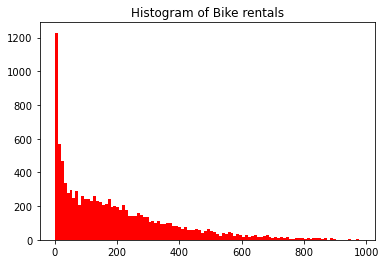

In [9]:
# distribution of hourly rentals
plt.hist(bk['count'], bins = int(np.sqrt(len(bk['count']))), color='red');
plt.title('Histogram of Bike rentals');

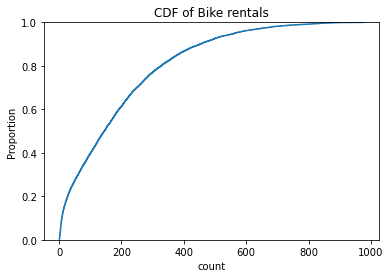

In [10]:
sns.ecdfplot(data=bk, x="count");
plt.title('CDF of Bike rentals');

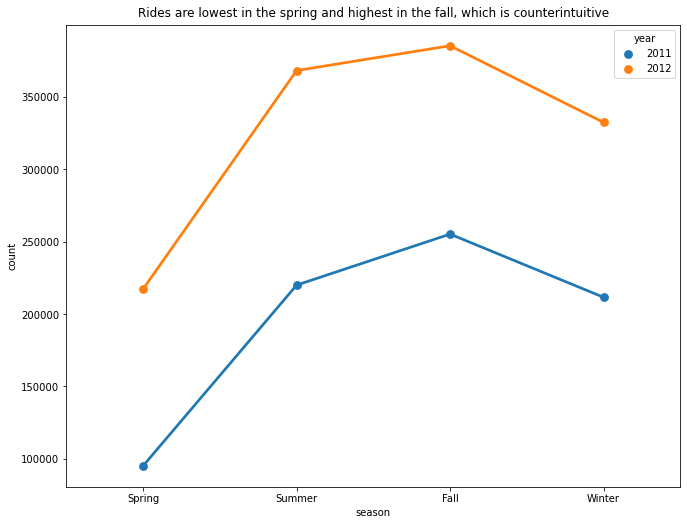

In [11]:
# ridership was substantially lower in 2012 than 2011
fig, ax = plt.subplots(figsize=(11, 8.5));
sns.pointplot(data = bk, x = 'season', y = 'count', hue = 'year', 
              estimator = np.sum, ci = None);
plt.title('Rides are lowest in the spring and highest in the fall, which is counterintuitive', 
          pad = 8);

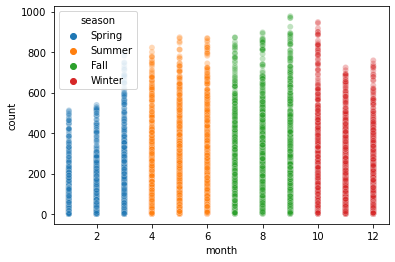

In [12]:
# this shows that most months are labelled with the wrong seasons
sns.scatterplot(data = bk, x = 'month', y = 'count', hue = 'season', alpha = 0.3);

In [13]:
# Fixing the seasons issue
# December, January, February = Winter; March, April, May = Spring
# June, July, August = Summer; September, October, November = Fall
bk.season = np.where((bk['month'] == 1) | (bk['month'] == 2) , 'Winter', bk.season)
bk.season = np.where((bk['month'] == 4) | (bk['month'] == 5), 'Spring', bk.season)
bk.season = np.where((bk['month'] == 7) | (bk['month'] == 8), 'Summer', bk.season)
bk.season = np.where((bk['month'] == 10) | (bk['month'] == 11), 'Fall', bk.season)

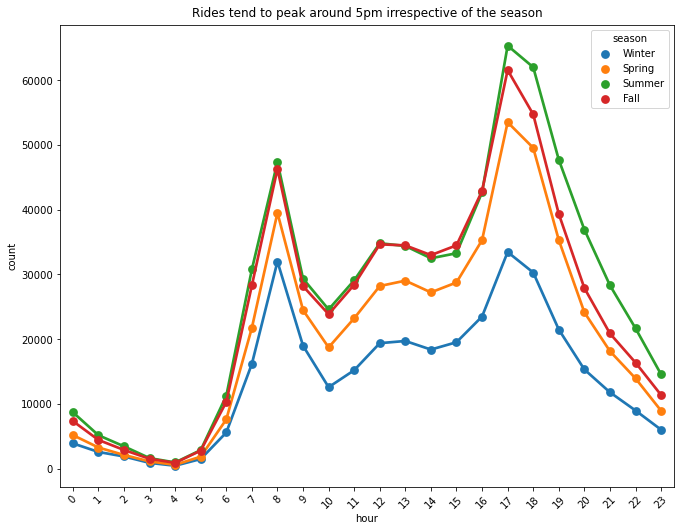

In [14]:
# hourly variation in ridership
fig = plt.subplots(figsize=(11, 8.5));
sns.pointplot(data = bk, x = 'hour', y = 'count', hue = 'season', estimator = np.sum, ci = None);
plt.title('Rides tend to peak around 5pm irrespective of the season', pad = 8);
plt.tick_params(axis='x', rotation=45);

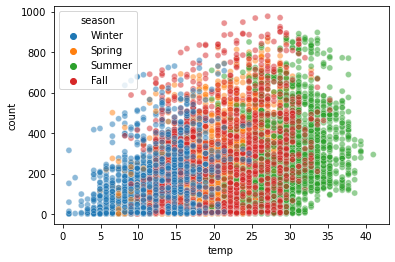

In [15]:
# absence of clustering points towards weak predictive power of seasons
sns.scatterplot(data = bk, x = 'temp', y = 'count', hue = 'season', alpha = 0.5);

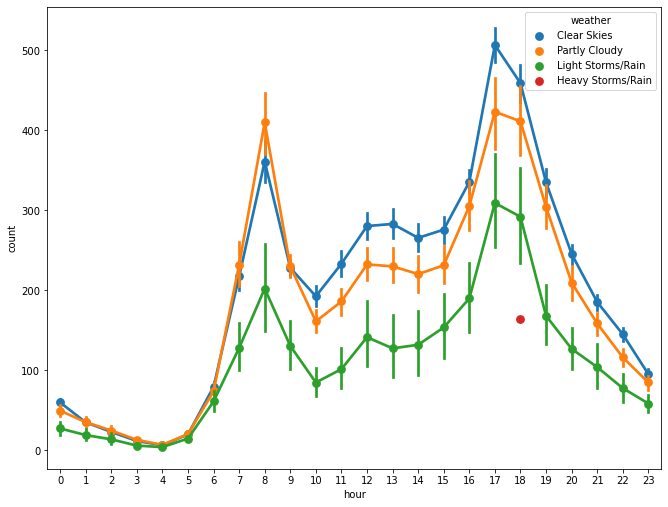

In [37]:
# better weather = more rides at peak times
fig = plt.subplots(figsize=(11, 8.5));
sns.pointplot(data = bk, x = 'hour', y = 'count', hue = 'weather', estimator = np.mean, alpha = 0.5);

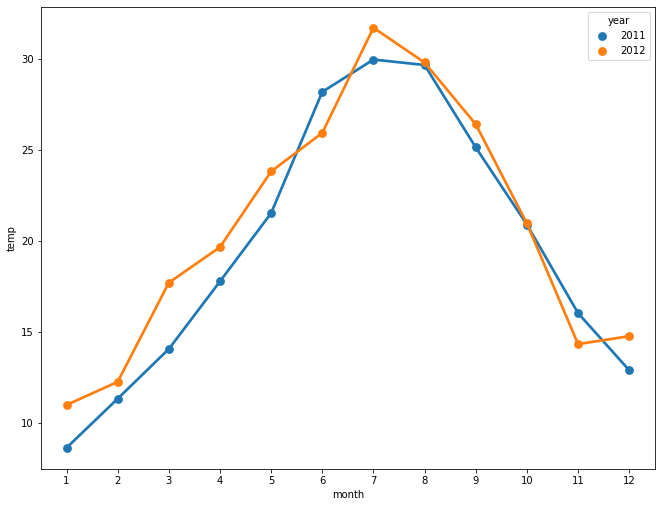

In [17]:
# no significant deviations in temperature patterns between the two years
fig = plt.subplots(figsize=(11, 8.5));
sns.pointplot(data = bk, x = 'month', y = 'temp', hue = 'year', estimator = np.mean, ci = None);

In [18]:
# checking the category levels for the weather variable
bk["weather"].value_counts(normalize = True)

Clear Skies          0.660665
Partly Cloudy        0.260334
Light Storms/Rain    0.078909
Heavy Storms/Rain    0.000092
Name: weather, dtype: float64

In [19]:
# creating binary weather and season variables for exploratory analysis
bk_dummy = pd.get_dummies(bk, prefix=["weather", "season"], columns=["weather", "season"], 
                          drop_first=False)

In [20]:
bk_dummy.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,count,month,year,hour,weather_Clear Skies,weather_Heavy Storms/Rain,weather_Light Storms/Rain,weather_Partly Cloudy,season_Fall,season_Spring,season_Summer,season_Winter
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,16,1,2011,0,1,0,0,0,0,0,0,1
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,40,1,2011,1,1,0,0,0,0,0,0,1
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,32,1,2011,2,1,0,0,0,0,0,0,1
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,13,1,2011,3,1,0,0,0,0,0,0,1
4,2011-01-01 04:00:00,0,0,9.84,14.395,75,0.0,1,1,2011,4,1,0,0,0,0,0,0,1


note that i'm using a pearson coefficient cutoff threshold of 0.3 for selecting regressors

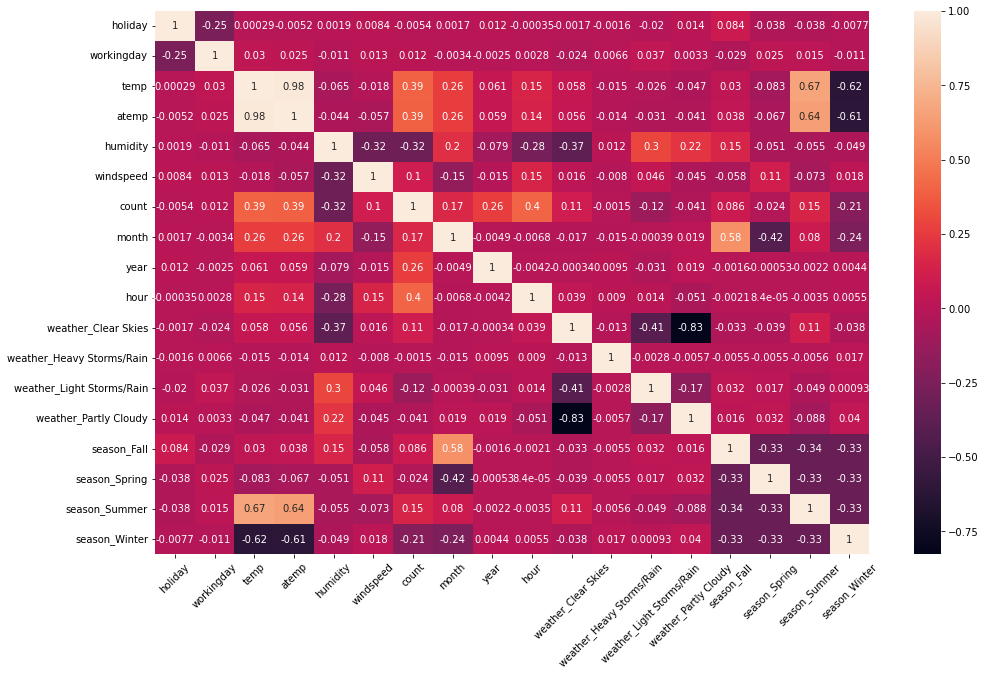

In [21]:
# temp, atemp, humidity, and hour appear to be the best predictors according to the correlation matrix
# but temp and atemp are nearly collinear, so we'll need to drop one of them
# surprisingly, neither weather nor season appears to have a noteworthy relationship with ridership
# note that the more extreme seasons (winter, summer) have a moderate, +ve correlation with temperature 
fig = plt.subplots(figsize=(16, 10));
sns.heatmap(bk_dummy.corr(), annot = True);
plt.tick_params(axis='x', rotation=45);

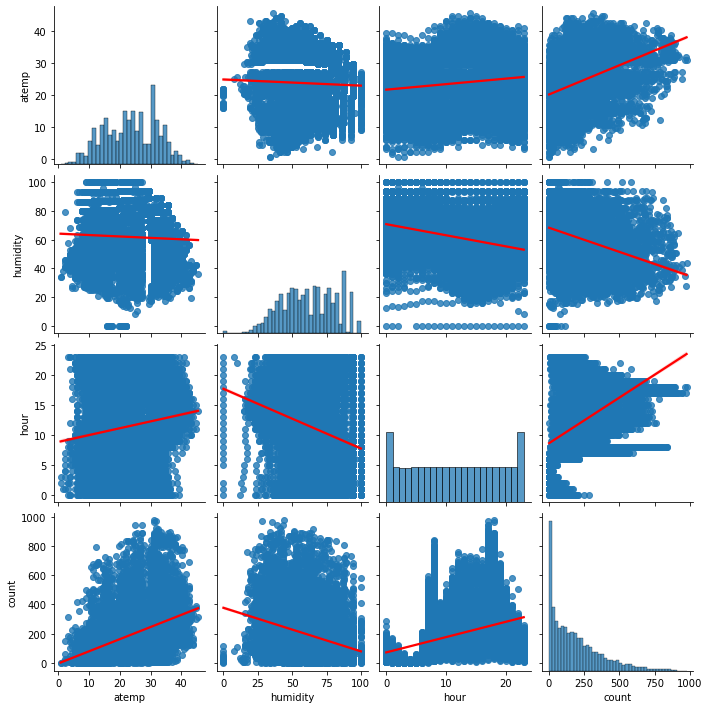

In [22]:
# pairplot of selected regressors shows hour doesn't have a linear relationship with count
sns.pairplot(bk[['atemp', 'humidity', 'hour', 'count']], kind="reg", 
             plot_kws={'line_kws':{'color':'red'}});

### Model Building

train test split 

In [23]:
# making our train-test split
X = bk[['atemp', 'humidity', 'hour']]
y = bk['count']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

ols regression + ols with polynomial features

In [25]:
# using statsmodels
X_sm = sm.add_constant(X_train)
model = sm.OLS(y_train,X_sm).fit()

/Users/Tochi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
# all regressors are statistically significant; autocorrelation doesn't appear to be a concern
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     1277.
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        00:44:23   Log-Likelihood:                -52459.
No. Observations:                8164   AIC:                         1.049e+05
Df Residuals:                    8160   BIC:                         1.050e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.6708      8.345      7.031      0.000      42.312      75.029
atemp          7.1372      0.197     36.192      0.000       6.751       7.524
humidity      -2.0435      0.090    -22.822      0.000      -2.219      -1.868
hour           7.8183      0.251     31.191      0.000       7.327       8.310
==============================================================================
Omnibus:                     1966.016   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4423.611
Skew:                           1.371   Prob(JB):                         0.00
Kurtosis:                       5.342   Cond. No.                         351.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# using scikit-learn
lr = LinearRegression().fit(X_train, y_train)

In [28]:
# calculating mse of model
cross_val_score(lr, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')

array([-21908.68432981, -21283.15957197, -23600.51711802, -23330.88470723,
       -21598.12017996])

In [29]:
# calculating mse of ols model on train set
abs(np.mean(cross_val_score(lr, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')))

22344.273181396038

In [30]:
# generating predicted values using ols model
pred = lr.predict(X_test)

In [31]:
# computing mse on test set and predicted values
mean_squared_error(y_test, pred)

22367.418120366703

In [32]:
# specifying a model with polynomial features to improve performance
pipe = Pipeline([('polynomial_features', PolynomialFeatures(degree=2, include_bias=False)), 
                 ('regressor', LinearRegression())])

In [33]:
# fitting the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial_features', PolynomialFeatures(include_bias=False)),
                ('regressor', LinearRegression())])

In [34]:
#generating predicted values of model with polynomial features
pred_2 = pipe.predict(X_test)

In [35]:
# model with polynomial features has lower mse than null model
mean_squared_error(y_test, pred_2)

18015.86820345126